In [ ]:
!pip install -q -U watermark
!pip install transformers==3

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.1+cu101
transformers: 3.0.0



In [ ]:
import pandas as pd
import numpy as np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


syncd dataset:                                                      Headlines
Date                                                         
2017-12-18  Trump EPA rule change exploits taxpayers for m...
2017-12-19  China aims to drastically cut greenhouse gas e...
2017-12-20  Marks & Spencer is first supermarket to publis...
2017-12-21  Wholesalers set to appeal after Tesco's takeov...
2017-12-22  Business live  UK car production heads for fir...
...                                                       ...
2020-07-13  Daimler talks with workers heat up, with 15,00...
2020-07-14  Free pizza and a 75-foot statue of Musk: the b...
2020-07-15    J.C. Penney to cut 1,000 jobs, close 152 stores
2020-07-16  IMF chief warns global economy 'not out of the...
2020-07-17  Stripe wins business following Wirecard's coll...

[646 rows x 1 columns] 
syncd label: 
           Date  Diff
0   2017-12-18   1.0
1   2017-12-19   1.0
2   2017-12-20   1.0
3   2017-12-21   1.0
4   2017-12-22   1.0
..         .

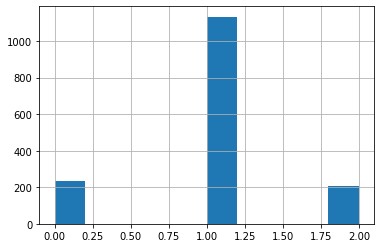

In [ ]:
# LABEL CONVERSION
dataset = pd.read_csv('Data.csv', parse_dates=['Time'])
djia = pd.read_csv('DJIA.csv', parse_dates=['Date'])
djia['Diff']= djia['Open'] / djia['Close']
djia = djia[['Date','Diff']]

hi_limit = 1.007
lo_limit = 0.993
djia['Diff'][(djia['Diff'] < hi_limit) & (djia['Diff'] > lo_limit)] = 1
djia['Diff'][djia['Diff'] >= hi_limit] = 2
djia['Diff'][(djia['Diff'] < lo_limit) & (djia['Diff'] > 0)] = 0


news_time = dataset[['Time']].groupby('Time').first()
price_time = djia[['Date']]
common_time = pd.merge(left=news_time, right=price_time, left_on='Time',right_on='Date')


common_dataset_ = pd.merge(left=common_time, right=dataset, left_on='Date', right_on='Time').drop(labels='Time', axis=1)
common_label_ = pd.merge(left=common_time, right=djia, left_on='Date', right_on='Date')
common_label = np.array(common_label_.drop(labels='Date', axis=1))

cd = common_dataset_.groupby('Date')
common_dataset = []
for i in cd:
  common_dataset.append(np.array(i[1]['Headlines']))

# CONFIRM SYNC
print('syncd dataset: ', cd.first(), '\nsyncd label: \n', common_label_)
print('length of syncd dataset: ', len(common_dataset), '\nlength of syncd label', len(common_label))

djia['Diff'].hist()

In [ ]:
# Prepare a 1d dataset and label namely, single_data, single_label
import matplotlib.pyplot as plt

data_list = []
label_list = []
for i in range(0, len(common_dataset)):
    for j in range(0, len(common_dataset[i])):
        if common_label[i] != 1:
            data_list.append(common_dataset[i][j])
            label_list.append(common_label[i])
            data_list.append(common_dataset[i][j])
            label_list.append(common_label[i])
        else:
            if j%2 == 0:
                data_list.append(common_dataset[i][j])
                label_list.append(common_label[i])

single_data = np.array(data_list)
single_label = np.array(label_list).reshape(-1,)

print(len(single_data), len(single_label))
np.histogram(single_label)[0]


45633 45633


array([15320,     0,     0,     0,     0, 14637,     0,     0,     0,
       15676])

In [ ]:
import transformers
from transformers import BertTokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
print('Tokenize a string: ', tokenizer.tokenize(common_dataset[0][0]))


Tokenize a string:  ['Trump', 'EPA', 'rule', 'change', 'exploits', 'tax', '##payers', 'for', 'mine', 'clean', '##up', ',', 'critics', 'say']


In [ ]:
encoding = tokenizer.encode_plus(
  common_dataset[0][0],
  max_length=32,
  add_special_tokens=True, 
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  
  truncation=True
)

# BUILD DATASET


import torch
from torch.utils.data import Dataset, DataLoader

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }



In [ ]:
MAX_LEN = 160

# train test split

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
import tensorflow as tf

t_X, val_X, t_Y, val_Y = train_test_split(single_data, single_label, test_size = 0.1)
train_X, test_X, train_Y, test_Y = train_test_split(t_X, t_Y, test_size = 0.1)

t_Y = tf.one_hot(t_Y, 3)
val_Y = tf.one_hot(val_Y, 3)
train_Y = tf.one_hot(train_Y, 3)
test_Y = tf.one_hot(test_Y, 3)



trainloader shape:  514


In [ ]:
#LSTM Model

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense, Input

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np


In [ ]:
# Tokenizing the sentences 

tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_X)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.num_words)

None


In [ ]:
# Tokenizing and padding the news headlines for LSTM input

def convert_to_sequences(input_array, max_seq_len = 0):
  token_list = tokenizer.texts_to_sequences(input_array)
  max_seq_len = max(max([len(x) for x in token_list]), max_seq_len)
  input_sequences = np.array(pad_sequences(token_list, maxlen=max_seq_len, padding='post'))
  return input_sequences, max_seq_len

In [ ]:
input_sequences = []

token_list, max_seq_len = convert_to_sequences(train_X, 0)
token_list.shape

(36962, 30)

In [ ]:
# # Building, training and fitting the LSTM model

import numpy

model = Sequential()

Xx = token_list

Yy = train_Y
model.add(Embedding(total_words, 10, input_length=Xx.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# print(Xx, Yy)

val_Xx, max_seq_len = convert_to_sequences(val_X, max_seq_len)

val_Yy = val_Y

# Fit the model
model.fit(Xx, Yy, epochs=15, batch_size=32, validation_data=(val_Xx, val_Yy))

Epoch 1/15
1156/1156 [==============================] - 120s 102ms/step - loss: 1.0986 - accuracy: 0.3461 - val_loss: 1.0812 - val_accuracy: 0.3983
Epoch 2/15
1156/1156 [==============================] - 117s 102ms/step - loss: 1.0425 - accuracy: 0.4544 - val_loss: 1.0179 - val_accuracy: 0.4761
Epoch 3/15
1156/1156 [==============================] - 117s 102ms/step - loss: 0.8786 - accuracy: 0.6011 - val_loss: 1.0090 - val_accuracy: 0.5175
Epoch 4/15
1156/1156 [==============================] - 116s 100ms/step - loss: 0.7418 - accuracy: 0.6900 - val_loss: 0.9729 - val_accuracy: 0.5550
Epoch 5/15
1156/1156 [==============================] - 118s 102ms/step - loss: 0.6411 - accuracy: 0.7430 - val_loss: 1.0062 - val_accuracy: 0.5660
Epoch 6/15
1156/1156 [==============================] - 117s 101ms/step - loss: 0.5751 - accuracy: 0.7696 - val_loss: 0.9558 - val_accuracy: 0.5982
Epoch 7/15
1156/1156 [==============================] - 117s 101ms/step - loss: 0.5075 - accuracy: 0.8044 - val_

In [ ]:
X_test2 = tokenizer.texts_to_matrix(
    test_X, mode='binary'
)

In [ ]:

Xx_test, max_seq_len = convert_to_sequences(test_X, max_seq_len)
Yy_test = test_Y 

test_Y.shape

TensorShape([4107, 3])

In [ ]:
Xx_test.shape

(4107, 30)

In [ ]:
Yy_test.shape

Yy.shape

val_Yy.shape

TensorShape([4564, 3])

In [ ]:

predicted_trend = model.predict(Xx_test)
print(predicted_trend.shape)


(4107, 3)


In [ ]:

print(predicted_trend.argmax(axis=-1))

predicted_trend_list = predicted_trend.argmax(axis=-1)
expected_trend_list = np.array(Yy_test).argmax(axis=-1)


print(expected_trend_list.shape, predicted_trend_list.shape)

[2 1 2 ... 0 2 1]
(4107,) (4107,)


In [ ]:
# Finding the accuarcy on the test data 

model.evaluate(Xx_test, Yy_test)

129/129 [==============================] - 1s 9ms/step - loss: 1.0294 - accuracy: 0.6898


[1.0293949842453003, 0.6897978782653809]

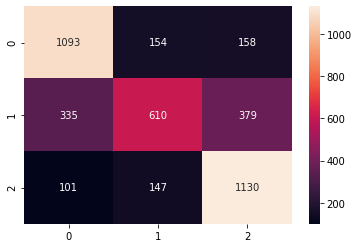

In [ ]:
# Confusion Matrix and Heat Map to see the results

from sklearn.metrics import confusion_matrix
from seaborn import heatmap

confusion_matrix = confusion_matrix(expected_trend_list, predicted_trend_list)
heatmap(confusion_matrix, annot=True, fmt='d')

In [ ]:
# Classification Report ffor LSTM
from sklearn.metrics import classification_report
print(classification_report(predicted_trend_list, expected_trend_list))

              precision    recall  f1-score   support

           0       0.78      0.71      0.75      1529
           1       0.46      0.67      0.55       911
           2       0.82      0.68      0.74      1667

    accuracy                           0.69      4107
   macro avg       0.69      0.69      0.68      4107
weighted avg       0.72      0.69      0.70      4107



In [ ]:
# saving the model
# model.save('model_v1')

INFO:tensorflow:Assets written to: model_v1/assets
